In [1]:
import pandas as pd
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.math import confusion_matrix
from tensorflow.keras import utils
from tensorflow.keras.optimizers import SGD 

import tensorflow as tf
tf.random.set_seed(42)

#from keras.utils import to_categorical
#from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data-capstone/fer2013/fer2013.csv')

In [3]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.tail()

,emotion,pixels,Usage
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest
35886,2,19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...,PrivateTest


In [5]:
df.shape

(35887, 3)

In [6]:
#0 - 'Angry'1 - 'Disgust'2 - 'Fear' 3 - 'Happy' 4 - 'Sad' 5 - 'Surprise'6 - 'Neutral'
emotion = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}

In [7]:
def image_plot(num):
    image1 = np.fromstring(df['pixels'][num], sep= ' ').reshape(48,48)
    return plt.imshow(image1, cmap='gray')

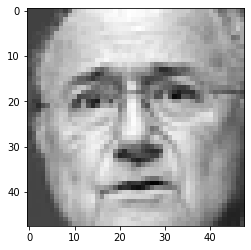

In [8]:
image_plot(5)

In [9]:
image1

array([[151., 150., 147., ..., 129., 140., 120.],
       [151., 149., 149., ..., 122., 141., 137.],
       [151., 151., 156., ..., 109., 123., 146.],
       ...,
       [188., 188., 121., ..., 185., 185., 186.],
       [188., 187., 196., ..., 186., 182., 187.],
       [186., 184., 185., ..., 193., 183., 184.]])

##  Preprocessing image data

In [33]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [13]:
df.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [14]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

## Formating the pixels category

## split the data into training and testing

#### Note: the original kaggle dataset had two test data sets, one for testing and one for competition submission.  Here I'll use all the test data for testing purposes

In [3]:
df_train = df.loc[df['Usage']=='Training']
df_test = df.loc[df['Usage']!='Training']
df_train.shape

(28709, 3)

## iterate through the rows and pull out the strings of numbers for the image

In [4]:
train_data =[]
for i in range(len(df_train)):
    image_train = np.fromstring(df_train['pixels'][i], sep= ' ').reshape(48, 48)
    image_train = image_train.astype(np.uint8)/255.0
    train_data.append(image_train)

In [11]:
len(train_data)

28709

In [12]:
df_test.head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


## Repeat the same process for the test data.  I used the above to refrence the index where the test data started in the original dataFrame.  An alternative would have been to re-index the dataframe.

In [5]:
#Needed to adjust the iteration values since the way we split the dataframe into train and test
test_data = []
for j in range(28709, (28709 + len(df_test))):
    image_test = np.fromstring(df_test['pixels'][j], sep= ' ').reshape(48, 48)
    image_test = image_test.astype(np.uint8)/255.0
    test_data.append(image_test)

In [6]:
len(image_test)

48

### The final touches on the X features data.  The input for the tensor model later needs to be (###, 48, 48, 1).  The ### is the number of images or rows.

In [7]:
X_train = np.array(train_data)
X_train = np.expand_dims(X_train, -1) 
X_test = np.array(test_data)
X_test = np.expand_dims(X_test, -1) 

In [8]:
X_train.shape

(28709, 48, 48, 1)

In [9]:
X_test.shape

(7178, 48, 48, 1)

### Reformat the y part of the data

pull out the column and convert it to categories.

In [10]:
y_train = df_train['emotion']
y_test = df_test['emotion']

y_train = utils.to_categorical(y_train, 7)
y_test = utils.to_categorical(y_test, 7)

### verify the shapes

In [11]:
y_test.shape

(7178, 7)

In [12]:
y_train.shape

(28709, 7)

In [13]:
y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [14]:
X_train

array([[[[0.2745098 ],
         [0.31372549],
         [0.32156863],
         ...,
         [0.20392157],
         [0.16862745],
         [0.16078431]],

        [[0.25490196],
         [0.23921569],
         [0.22745098],
         ...,
         [0.21960784],
         [0.20392157],
         [0.17254902]],

        [[0.19607843],
         [0.16862745],
         [0.21176471],
         ...,
         [0.19215686],
         [0.21960784],
         [0.18431373]],

        ...,

        [[0.35686275],
         [0.25490196],
         [0.16470588],
         ...,
         [0.28235294],
         [0.21960784],
         [0.16862745]],

        [[0.30196078],
         [0.32156863],
         [0.30980392],
         ...,
         [0.41176471],
         [0.2745098 ],
         [0.18039216]],

        [[0.30196078],
         [0.28235294],
         [0.32941176],
         ...,
         [0.41568627],
         [0.42745098],
         [0.32156863]]],


       [[[0.59215686],
         [0.58823529],
         [0.57

# keras Image preprocessing

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_gen = datagen.flow_from_directory(
    '../data-capstone/fer2013_2/train',
    target_size=(299,299),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 28709 images belonging to 7 classes.


In [21]:
test_gen = datagen.flow_from_directory(
    '../data-capstone/fer2013_2/test',
    target_size=(299,299),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 7178 images belonging to 7 classes.


# building the model With transfer learning

In [22]:
from keras.applications.inception_v3 import InceptionV3

In [26]:
conv_base = InceptionV3(
    weights='imagenet',
    input_shape=(299, 299, 3),
    include_top=False
)

87924736/87910968 [==============================] - 2s 0us/step


In [28]:
l_train = conv_base.predict(train_gen)

KeyboardInterrupt: 

In [ ]:
l_test = conv_base.predict(test_gen)

In [ ]:
model = Sequential()
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
history = model.fit(l_train, train_gen.labels, validation_data=(l_test, test_gen.labels), epochs=20)

# MODEL

In [22]:

model = Sequential()
model.add(Conv2D(
      filters=64,
      kernel_size=(3, 3),
      activation='relu',
      input_shape=(48, 48, 1)
))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(
#      filters=128,
#      kernel_size =(3, 3),
#      activation ='relu'
#))
#model.add(Conv2D(
#      filters=128,
#      kernel_size =(3, 3),
#      activation ='relu'
#))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               8667392   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 8,669,831
Trainable params: 8,669,831
Non-trainable params: 0
______________________________________________

In [24]:
history = model.fit(
      X_train,
      y_train, 
      #batch_size=64,
      validation_data=(X_test, y_test),
      epochs=5,
      verbose=1)

Epoch 1/5
898/898 [==============================] - 139s 154ms/step - loss: 1.6562 - accuracy: 0.3491 - val_loss: 1.5141 - val_accuracy: 0.4209
Epoch 2/5
898/898 [==============================] - 135s 151ms/step - loss: 1.4918 - accuracy: 0.4254 - val_loss: 1.4317 - val_accuracy: 0.4430
Epoch 3/5
898/898 [==============================] - 128s 142ms/step - loss: 1.4065 - accuracy: 0.4619 - val_loss: 1.4129 - val_accuracy: 0.4525
Epoch 4/5
898/898 [==============================] - 128s 143ms/step - loss: 1.3279 - accuracy: 0.4914 - val_loss: 1.3759 - val_accuracy: 0.4738
Epoch 5/5
898/898 [==============================] - 127s 141ms/step - loss: 1.2453 - accuracy: 0.5256 - val_loss: 1.3619 - val_accuracy: 0.4753


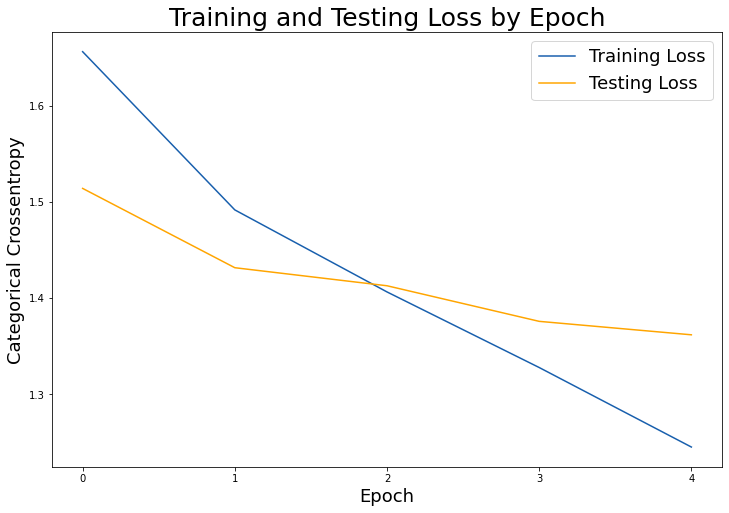

In [25]:
# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Loss', color='#185fad')
plt.plot(test_loss, label='Testing Loss', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);

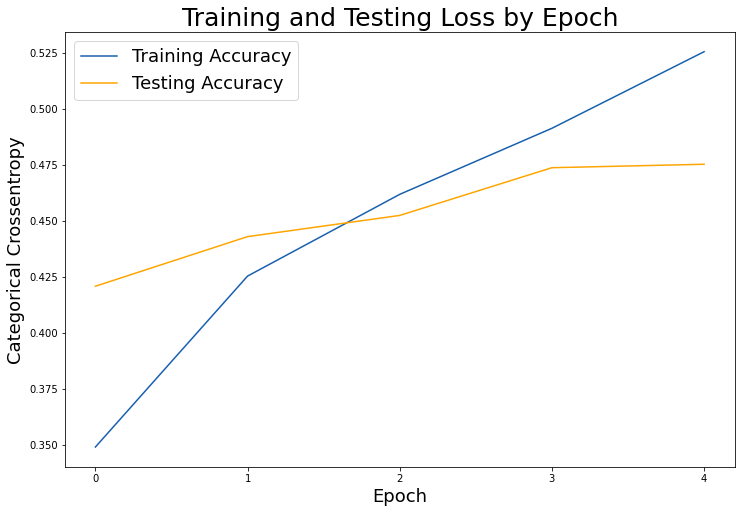

In [26]:
# Check out our train loss and test loss over epochs.
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_acc, label='Training Accuracy', color='#185fad')
plt.plot(test_acc, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Loss by Epoch', fontsize=25)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Categorical Crossentropy', fontsize=18)
plt.xticks(epoch_labels, epoch_labels)    # ticks, labels

plt.legend(fontsize=18);